# Generative Adersarial Networks (GANs)

In the landmark paper [Goodfellow et al.](https://arxiv.org/abs/1406.2661) , published in 2014, authors introduced this novel paradigm for generative models. The fundamental idea proposed in the work is to train a Generator Network in adversarial setup, where a discriminator network downstream critiques the generated samples.

Simply put, generator network generates a sample and discriminator network classifies it as a real or fake. Discriminator is also provided with real samples. The objective functions takes the following form:

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where <br>
$x \sim p_\text{data}$ are samples from the input data. <br>
$z \sim p(z)$ are the random noise samples.<br>
$G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real.

## Training Setup

In this example illustrates distributed (data parallel) training of DC-GAN model using MNIST dataset on a TPU device. A TPU device consistes of 4 chips (8 cores; 2 cores/chip). Both the discriminator and generator replica are created on each of 8 cores. The dataset is splitted across the 8 cores. 

<br> At every training step, each of the cores perfoms the forward (loss computation) and backward (gradient computation) on the given minibatch and then [all_reduce](https://www.tensorflow.org/xla/operation_semantics#allreduce) is performed across TPU cores to update the parameters. Notice `xm.optimizer_step` call in the discriminator and optimizer train steps.


General GAN training looks like:

1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

We will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

Therefore the training lopp in this notebook will entail:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$


In [3]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.optim import Adam
import torch.nn.functional as F

import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu



# Setting up the Global Flags

In the current setup, Discriminator network was chosen to be a smaller capacity than generator. Even with similar capacity netowrks, generator update path is deeper than Discriminator. Therefore uneven learning rates chosen here seems to yield a better convergence. 


In [20]:
# Define Parameters
FLAGS = {}
FLAGS['datadir'] = "/tmp/mnist"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4 #Threads for data loader
FLAGS['gen_learning_rate'] = 0.01
FLAGS['disc_learning_rate'] = 0.001
FLAGS['num_epochs'] = 20
FLAGS['num_cores'] = 8

In [5]:
%matplotlib inline
RESULT_IMG_PATH = '/tmp/test_result.png'
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from IPython import display 

    
def plot_results(images):
    #display.clear_output()
    num_images = images.shape[0]
    fig, axes = plt.subplots(4, 6, figsize=(11, 9))

    for i, ax in enumerate(fig.axes):
        ax.axis('off') 
        if i >= num_images:
          continue
        img = images[i]
        img = img.squeeze() # [1,Y,X] -> [Y,X]
        ax.imshow(img)
    plt.savefig(RESULT_IMG_PATH, transparent=True)

In [6]:
def mnist_data():
    compose = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(FLAGS['datadir'])
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [8]:
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(4*4*64, 1)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2), 0.01)
        x = self.bn1(x)
        x = F.leaky_relu(F.max_pool2d(self.conv2(x), 2), 0.01)
        x = self.bn2(x)
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x), 0.01)
        return torch.sigmoid(x)            
        

In [9]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        self.linear1 = nn.Linear(100, 1024) # relue activation
        self.bn1 = nn.BatchNorm1d(1024)
        self.linear2 = nn.Linear(1024, 7*7*128) # relu activation
        self.bn2 = nn.BatchNorm1d(7*7*128) # reshape to (-1, 7, 7, 128)
        self.conv1 = nn.ConvTranspose2d(
            in_channels=128, 
            out_channels=64, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False
        ) #relu activation
        self.bn3 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(
            in_channels=64, 
            out_channels=1, 
            kernel_size=4,
            stride=2, 
            padding=1, 
            bias=False
        ) # tanh activation
        
        
            
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = x.view(x.shape[0], 128, 7, 7)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv2(x)
        x = torch.tanh(x)
        return x

    


In [10]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [11]:
def real_data_target(size, device):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data.to(device)

def fake_data_target(size, device):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data.to(device)

In [12]:
# Noise
def noise(size, device):
    n = Variable(torch.randn(size, 100))
    return n.to(device)

# Note on the use of .detach() method

You will notice in the following code snippet that when the gnerator is used to create the `fake_data`, .detach() call is used to create a new view of the fake_data tensor for which the operations will not be recorded for gradient computation.<br>

Since fake_date is an output of an nn.module, by default, pytorch will record all the operations performed on this tensor during the forward pass as DAG. And after the backward pass these DAG and corresponding operations are cleared (unless `retain_graph=True`).
Therefore such a tensor can be part of only one cone of logic where the forward and backward pass is done. If there are two loss function where this tensor is used and backward pass is performed on these two function (or even sum of the functions) for the second backward pass the operations DAG will not be found, leading to an error.

The second place, where detach() call is used is when a numpy() call is to be made to tensor (for plotting purposes). Pytorch also requires that requires_grad should not be true on these tensor. (Ref: Error: `
RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.`)

In [21]:
def train_gan(rank):
    torch.manual_seed(1)
    
    if not xm.is_master_ordinal():
        # Barrier: Wait until master is done downloading
        xm.rendezvous('download_only_once')
    # Dataset
    data = mnist_data()
    if xm.is_master_ordinal():
        # Master is done, other workers can proceed now
        xm.rendezvous('download_only_once')
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        data,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True)
    

    # Create loader with data, so that we can iterate over it
    #train_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
    train_loader = torch.utils.data.DataLoader(
      data,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

    # Num batches
    num_batches = len(train_loader)
    
    device = xm.xla_device()
    
    generator = GenerativeNet().to(device)
    generator.apply(init_weights)

    discriminator = DiscriminativeNet().to(device)
    discriminator.apply(init_weights)
    
    # Optimizers
    d_optimizer = Adam(discriminator.parameters(), lr=FLAGS['disc_learning_rate'], betas=(0.5, 0.999))
    g_optimizer = Adam(generator.parameters(), lr=FLAGS['gen_learning_rate'], betas=(0.5, 0.999))

    # Number of epochs
    num_epochs = FLAGS['num_epochs'] 
    # Loss function
    loss = nn.BCELoss()
    
    num_test_samples = 24
    test_noise = noise(num_test_samples, device)
    
    def train_step_discriminator(optimizer, real_data, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()

        # 1. Train on Real Data
        prediction_real = discriminator(real_data)
        # Calculate error and backpropagate
        error_real = loss(prediction_real, real_data_target(real_data.size(0), device))
        

        # 2. Train on Fake Data
        prediction_fake = discriminator(fake_data)
        # Calculate error and backpropagate

        error_fake = loss(prediction_fake, fake_data_target(real_data.size(0), device))
        total_error = error_real + error_fake
        total_error.backward()

        # Update weights with gradients
        xm.optimizer_step(optimizer)

        return total_error, prediction_real, prediction_fake
        #return (0, 0, 0)

    def train_step_generator(optimizer, fake_data, device):
        # Reset gradients
        optimizer.zero_grad()
        # Sample noise and generate fake data
        prediction = discriminator(fake_data)
        # Calculate error and backpropagate
        error = loss(prediction, real_data_target(prediction.size(0), device))
        error.backward()
        # Update weights with gradients
        xm.optimizer_step(optimizer)

        # Return error
        return error

    # Notice the use of .detach() when fake_data is to passed into discriminator
    def train_loop_fn(loader):
        tracker = xm.RateTracker()
        for n_batch, (real_batch,_) in enumerate(loader):
            # Train Step Descriminator
            real_data = Variable(real_batch).to(device)
            fake_data = generator(noise(real_data.size(0), device))
            d_error, d_pred_real, d_pred_fake = train_step_discriminator(d_optimizer,
                                                                real_data, fake_data.detach(), device)
            #Train Step Generator
            fake_data = generator(noise(real_batch.size(0), device))
            g_error = train_step_generator(g_optimizer, fake_data, device)
            #print(f'D_ERROR: {d_error.item()}, G_ERROR: {g_error.item()}')
        return d_error.item(), g_error.item()


    for epoch in range(1, FLAGS['num_epochs'] +1):
        para_loader = pl.ParallelLoader(train_loader, [device])
        d_error, g_error = train_loop_fn (para_loader.per_device_loader(device))
        xm.master_print("Finished training epoch {}: D_error:{}, G_error: {}".format(epoch, d_error, g_error))
        if rank == 0 and epoch %5 == 0:
            # Retrieve tensors that are on TPU core 0 and plot.
            plot_results(generator(test_noise).detach().cpu())

# Start training processes
def _mp_fn(rank, flags):
    global FLAGS
    FLAGS = flags
    torch.set_default_tensor_type('torch.FloatTensor')
    train_gan(rank)

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')



Finished training epoch 1: D_error:1.3498919010162354, G_error: 0.6677162051200867
Finished training epoch 2: D_error:1.3487882614135742, G_error: 0.6705252528190613
Finished training epoch 3: D_error:1.2551052570343018, G_error: 0.6819852590560913
Finished training epoch 4: D_error:1.2364991903305054, G_error: 0.6874980330467224
Finished training epoch 5: D_error:1.2472574710845947, G_error: 0.693427562713623
Finished training epoch 6: D_error:1.2205075025558472, G_error: 0.6774481534957886
Finished training epoch 7: D_error:1.170775055885315, G_error: 0.6792863607406616
Finished training epoch 8: D_error:1.1061102151870728, G_error: 0.6157580018043518
Finished training epoch 9: D_error:1.1004109382629395, G_error: 0.6666254997253418
Finished training epoch 10: D_error:1.0711205005645752, G_error: 0.6668726205825806
Finished training epoch 11: D_error:1.0449901819229126, G_error: 0.6603497862815857
Finished training epoch 12: D_error:1.099801778793335, G_error: 0.6934622526168823
Fini

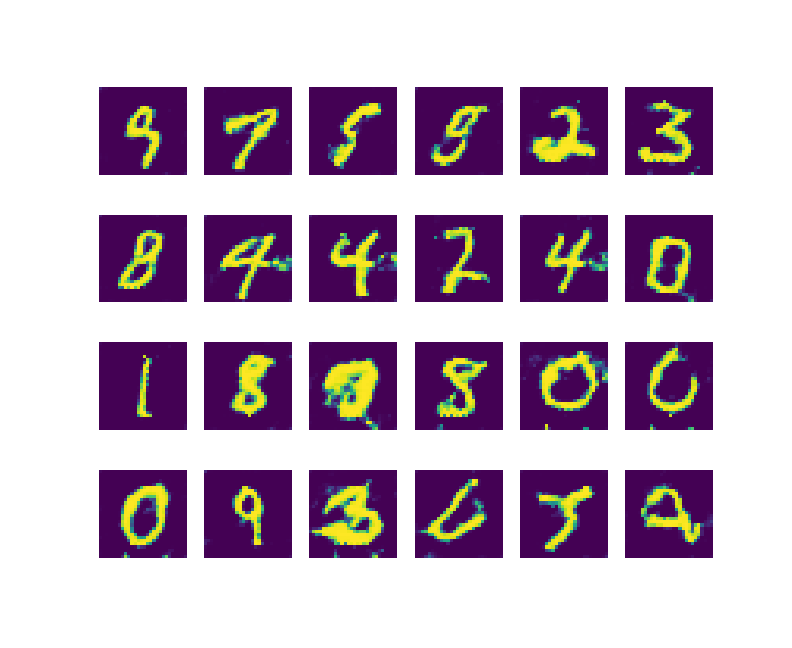

In [22]:
# Visualize generated images
from IPython.display import Image
Image(filename=RESULT_IMG_PATH)

## References:
[Training GAN from Scratch] (https://github.com/diegoalejogm/gans) <br>
[CS231n] (http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture13.pdf)